## **NYC COLLISION DATA ANALYSIS**
##### Data for the Year of 2025

### ***Author: Marzieh Safari***

#### Analyses were done on three tables on NYC OpenData repository for Public Safety 

##### **Data Sources:**
* Motor Vehicle Collisions - Crashes
* Motor Vehicle Collisions - Person
* Motor Vehicle Collisions - Vehicles


##### **Objective:**
Identify corresponding factors, including vehicle makes, driver's, and person's sex involved in the crashes.

Further analysis will be done on other factors like location and wheather in near future.

#### **Applied Data Science Toolkit:**
* Python
* SQL
* Databases
* SQLite3
* API calls
* Jupyter notebook
* Python libraries like Matplotlib and Seaborn
* Excel

### **Summary of codes will be shown here:**

**In order to get access to the datasets on the NYC OpenData, needed authentication, then registered for the App Token for API calls.** 

**After API calls, I stored the data in csv formats and transfered them to a SQLite database on cloud as dataframes for analyses with SQL.**

*Import the required modules*

In [ ]:
%pip install pandas
%pip install ipython-sql
%pip install ipython-sql prettytable 
%pip install requests
import prettytable
prettytable.DEFAULT = 'DEFAULT'

*Create a connection for a database on cloud*

In [ ]:
import sqlite3
con = sqlite3.connect("NYCCOLLISIONDATA.db")
cur = con.cursor()

*Load the SQL magic extension*

In [ ]:
%load_ext sql

*Connect to a SQLite database*

In [ ]:
%sql sqlite:///NYCCOLLISIONDATA.db

*API calls and loading data to the database in brief:*

In [ ]:
import pandas as pd
import requests
import io
import csv
import sqlite3     


DATASET_ID = '...'
RAW_DATA1 = 'raw_nyc_crashes.csv'

sql_query = f"SELECT count(collision_id) FROM `{DATASET_ID}` WHERE YEAR(crash_date) = 2025"

headers = {
    'Host': '...',
    'Accept': 'application/csv',
    'X-App-Token': ...
}
params = {
    '$query': sql_query
}
url = f"https://data/{DATASET_ID}/query.csv"
try:
    response = requests.get(url, headers=headers, params=params)
    csv_data = response.text
    df1 = pd.read_csv(io.StringIO(csv_data)) 
    df1.to_csv(RAW_DATA1, index=False)
   
except requests.exceptions.HTTPError as errh:
    print(f"HTTP Error (Likely 403 Forbidden): {errh}")


#Define the input path
file_path1 = r"..../raw_nyc_crashes.csv"
date_column = 'crash_date'
chunk_size = 100 

chunk_iterator1 = pd.read_csv(
    file_path1,
    chunksize=chunk_size,
    parse_dates=[date_column],
    low_memory=False
)
#Filter each chunk and combine the results for year 2025
df1_2025 = pd.concat((
    chunk[chunk[date_column].dt.year == 2025]
    for chunk in chunk_iterator1
))
print(f"Loaded and filtered {len(df1_2025)} rows for 2025.")
#Clean the dataset
COLUMNS_TO_KEEP = [
    'crash_date',
    'collision_id',
    'latitude',
    'longitude',
    'number_of_persons_injured',
    'number_of_persons_killed'
]

df1_essential = df1_2025[COLUMNS_TO_KEEP]
df1_filtered = df1_essential.dropna(how='any')
df1_limited = df1_filtered.iloc[:1000] #only the first 1000 rows were read.

#Export data (only 1000 rows) to database 
df1_limited.to_sql("NYC_CRASHES", con, if_exists='replace', index=False, method="multi")

#### **SQL queries were done based on "Collision_id" as primary key in the Crashes dataset, and as foreign key in the Vehicles and Persons datasets.** 

*Number of people injured, grouped by drivers' sex:*

In [ ]:
%sql SELECT COUNT(P.collision_id), \
            C.collision_id, C.latitude, C.longitude, \
            V.collision_id, V.driver_sex \
            FROM NYC_CRASHES C \
            INNER JOIN NYC_VEHICLES V ON C.collision_id = V.collision_id\
            INNER JOIN NYC_PERSONS P ON C.collision_id = P.collision_id \
            GROUP BY V.driver_sex \
            ORDER BY P.crash_date DESC;

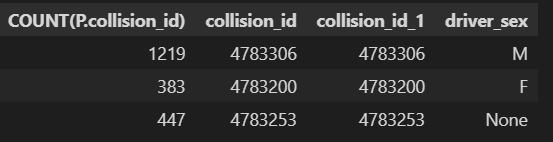

*For male drivers, how many victims were males and females:*

In [ ]:
%sql SELECT COUNT(P.collision_id), P.person_sex, \
            C.collision_id, \
            V.collision_id, V.driver_sex \
            FROM NYC_CRASHES C \
            INNER JOIN NYC_VEHICLES V ON C.collision_id = V.collision_id\
            INNER JOIN NYC_PERSONS P ON C.collision_id = P.collision_id \
            WHERE V.driver_sex = 'M' \
            GROUP BY P.person_sex\
            ORDER BY P.crash_date DESC;

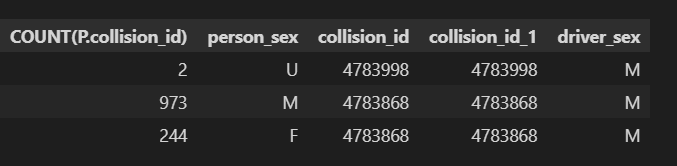

*Where were those locations for the highest occurrence of crashes caused by male drivers:*

In [ ]:
%sql SELECT COUNT(P.collision_id), P.person_sex, P.person_injury, \
            C.latitude, C.longitude, count(C.number_of_persons_injured), \
            V.driver_sex \
            FROM NYC_CRASHES C \
            INNER JOIN NYC_VEHICLES V ON C.collision_id = V.collision_id\
            INNER JOIN NYC_PERSONS P ON C.collision_id = P.collision_id \
            WHERE V.driver_sex = 'M' AND P.person_sex = 'M'\
            GROUP BY C.number_of_persons_injured \
            ORDER BY P.crash_date DESC;

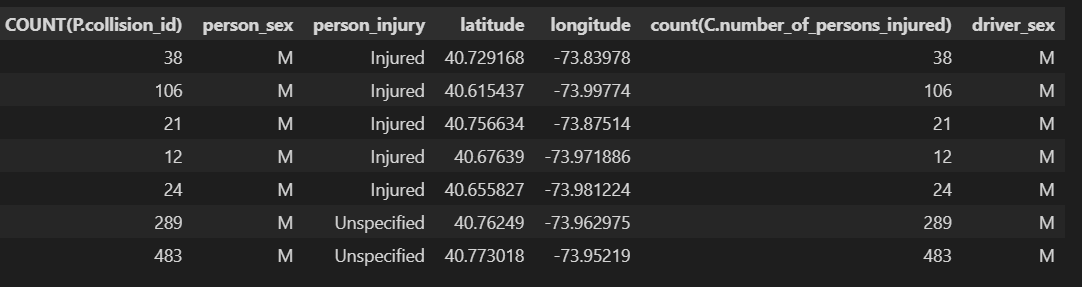

### **Producing graphs for the analyses:**

#### *matplotlib and seaborn modules were used to produce graphs for this analysis.*

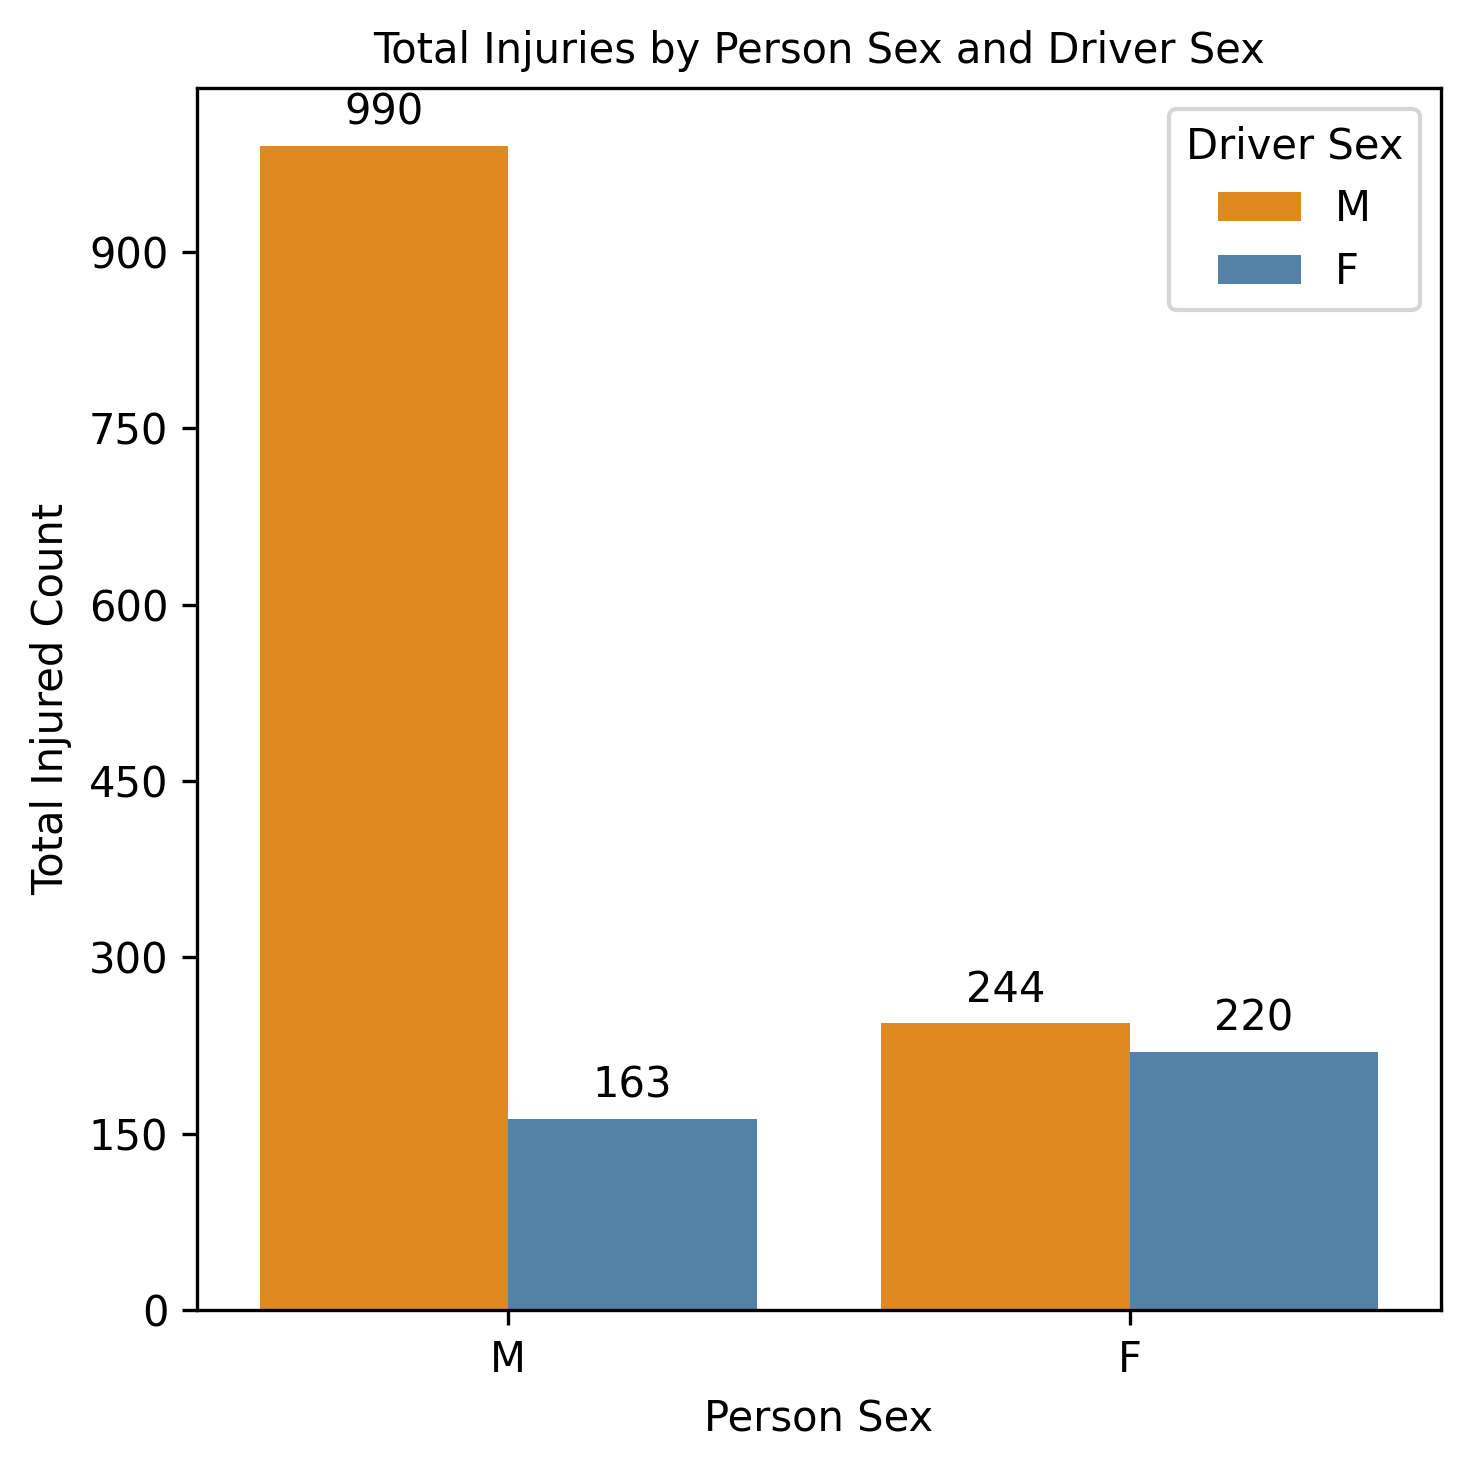

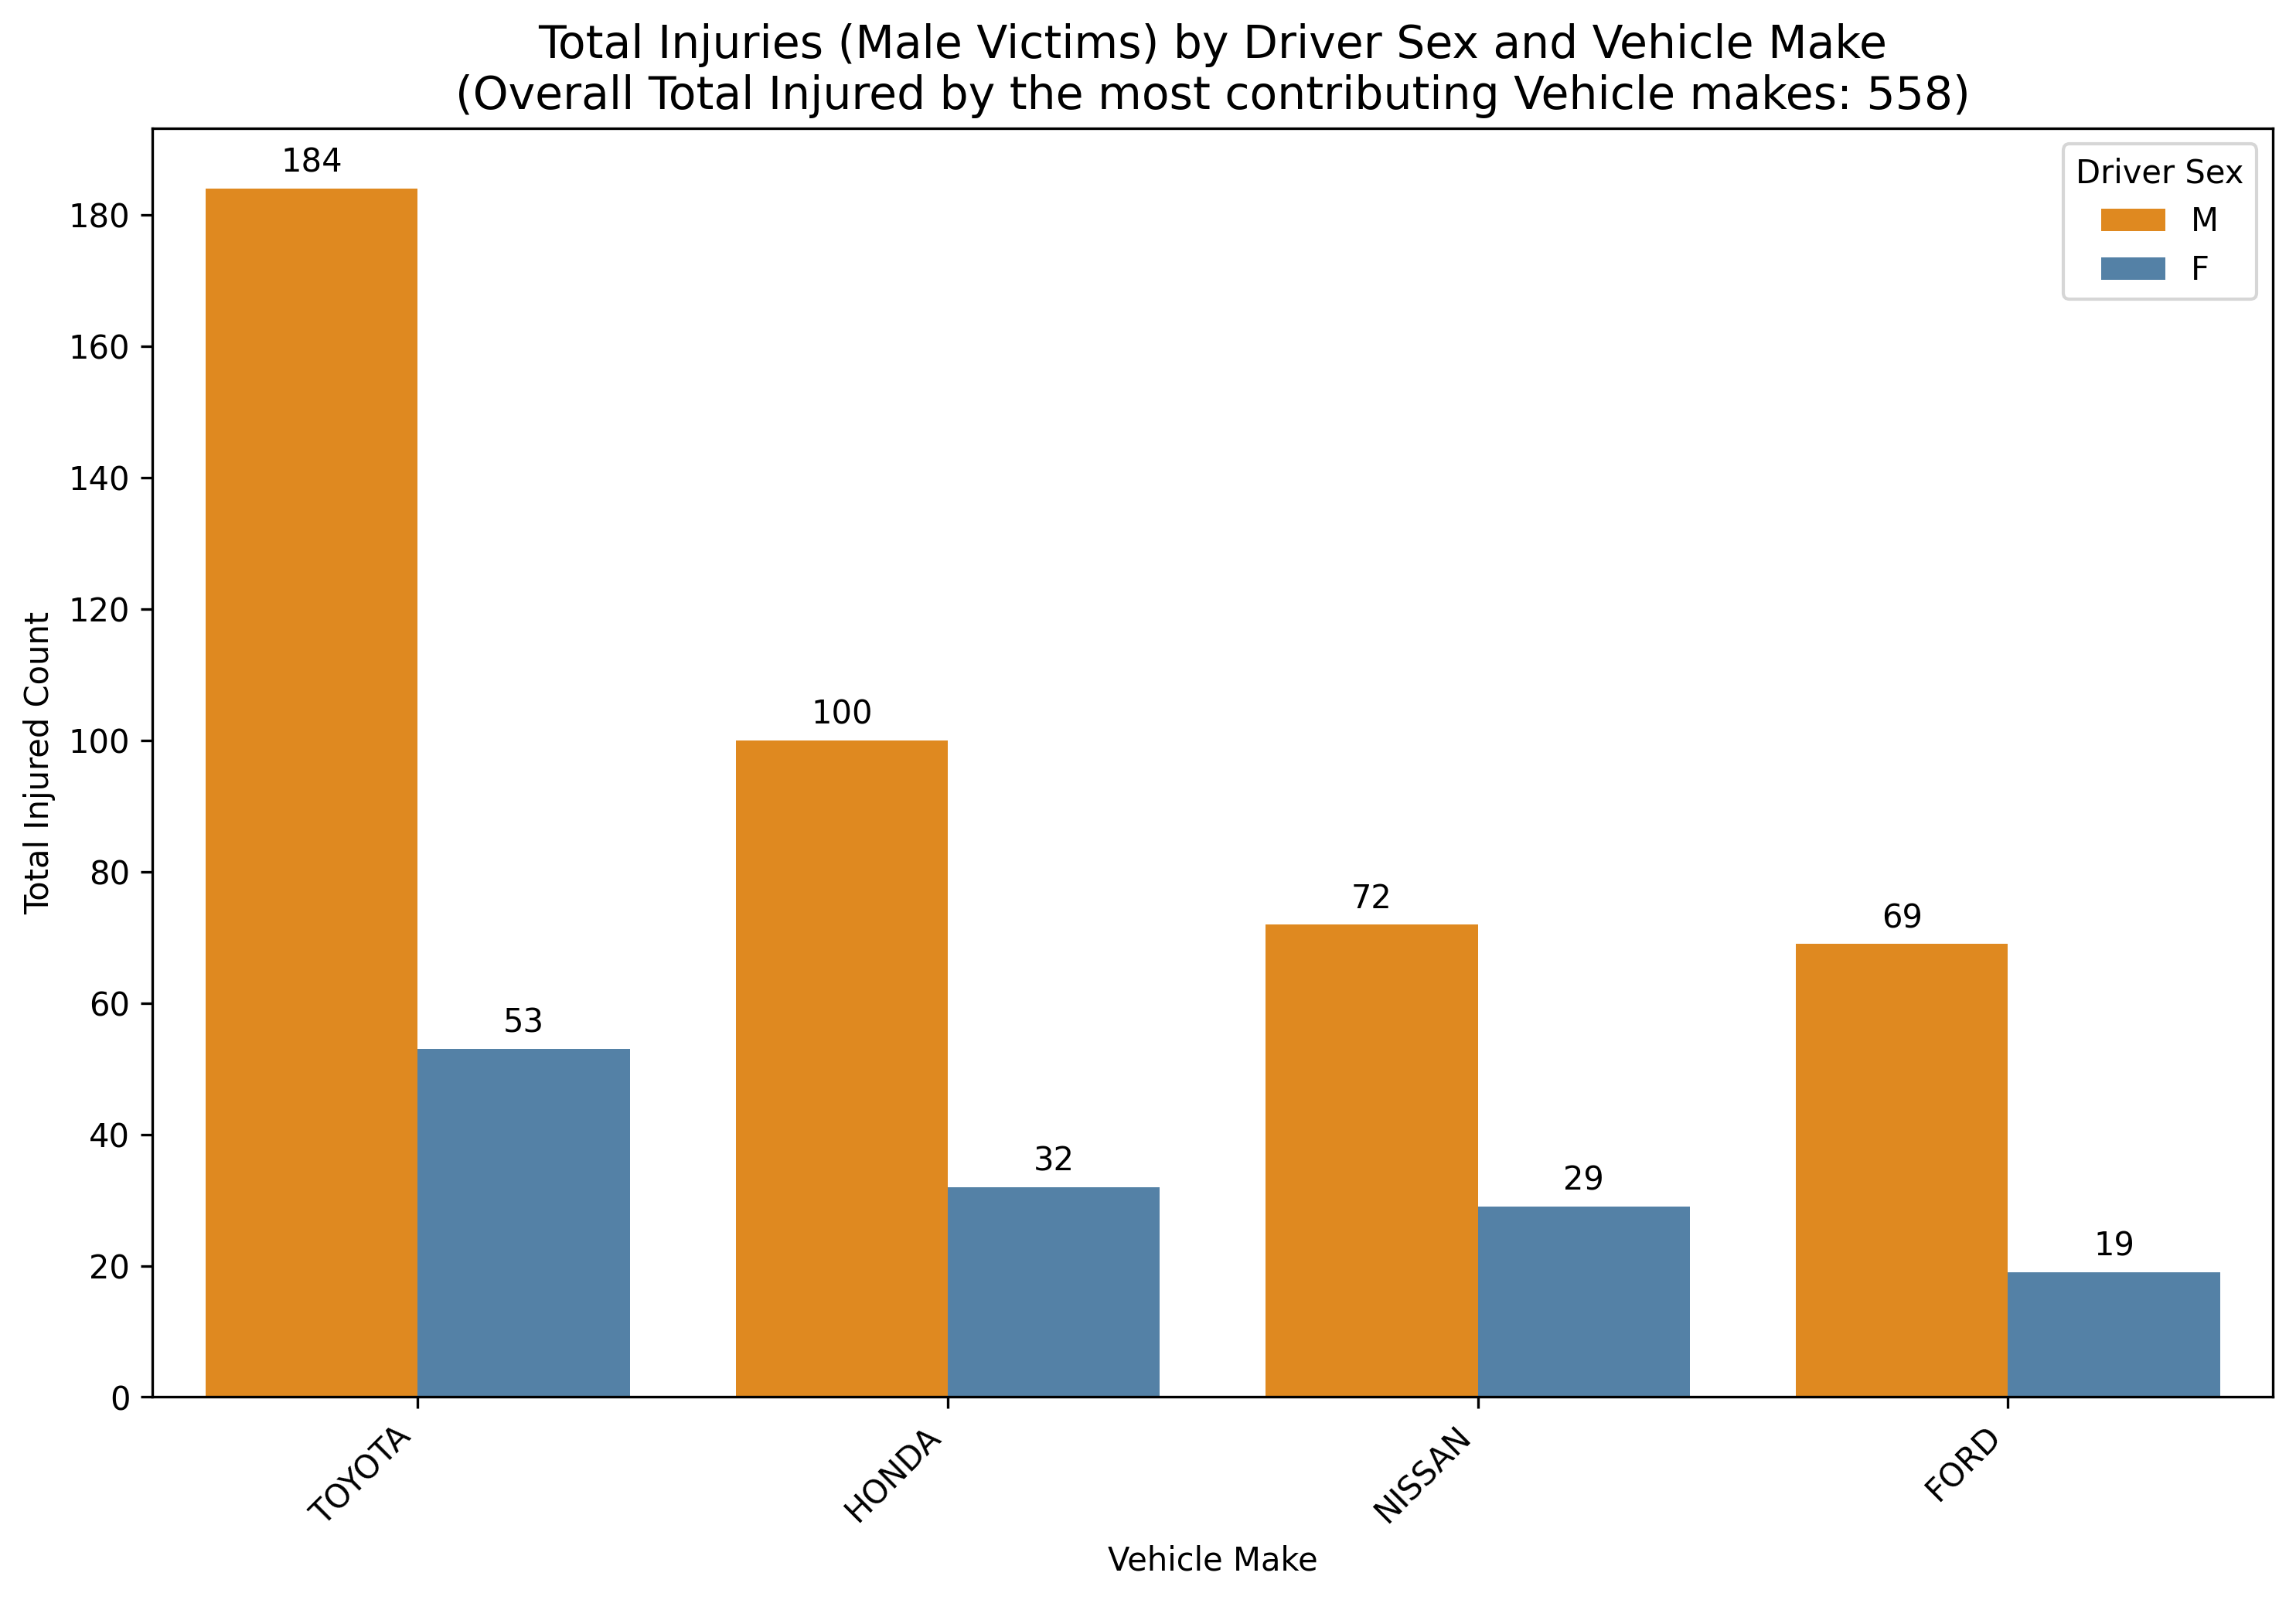

## Conclusions:

**Based on these findings:**
* **Male drivers**
* **Vehicle makes including TOYOTA, HONDA, NISSAN, and FORD**

are responsible for most crashes.

### Next steps:
* Indentify the other contributing factors in the crashes including the time of the year and location.